In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets
from exp_analysis_class import exp_analysis

In [3]:
from Likelihood import LEff
import emcee
from getdist import plots, MCSamples
import corner

In [4]:
case = 'heavy'
save_folder = (f'../fig/kde_test_2d/mcmc_minimal_{case}/' + case + '/')
!mkdir -p $save_folder
my_exp_analysis = exp_analysis(case)
my_exp_analysis.load_df_base(1000000)

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

In [7]:
def m4_mz_light_posterior(parameters, observed_events, m4_values, m4_limits, mz_values, mz_limits, span_2d, smooth_m4, smooth_mz, actual_weights):
    if (parameters[0] < m4_limits[0]) or (parameters[0] > m4_limits[1]) or (parameters[1] < mz_limits[0]) or (parameters[1] > mz_limits[1] or (parameters[0] <= parameters[1])):
        return -np.inf
    else:
        mu_kde, sigma2_kde = mu_sigma2_of_theta_fast(parameters[0], parameters[1], m4_values, mz_values, span_2d, smooth_m4, smooth_mz, actual_weights)
        return LEff(observed_events, mu_kde, sigma2_kde)

In [8]:
def m4_mz_mu_posterior(parameters, observed_events, m4_values, m4_limits, mz_values, mz_limits, span_2d, smooth_m4, smooth_mz, actual_weights, Vmu4, alpha_epsilon2, int_x, int_y, int_z, length_x, length_y, length_z):
    '''Posterior in the minimal model: parameters = [m4, mz, mu_Vmu4, mu_alpha_epsilon2]'''
    if (parameters[0] < m4_limits[0]) or (parameters[0] > m4_limits[1]) or (parameters[1] < mz_limits[0]) or (parameters[1] > mz_limits[1] or (parameters[0] <= parameters[1])) or (parameters[2] <= 0) or (parameters[3] <= 0):
        return -np.inf
    else:
        actual_Vmu4 = Vmu4 * parameters[2]
        actual_alpha_epsilon2 = alpha_epsilon2 * parameters[3]
        ctau = ctau_light(parameters[0], parameters[1], actual_Vmu4)
        mu_kde, sigma2_kde = mu_sigma2_of_theta_full(parameters[0], parameters[1], m4_values, mz_values, span_2d, smooth_m4, smooth_mz, actual_weights, ctau, int_x, int_y, int_z, length_x, length_y, length_z, parameters[2]*parameters[3])
        return LEff(observed_events, mu_kde, sigma2_kde)

In [ ]:
def m4_mz_heavy_posterior(parameters, observed_events, m4_values, m4_limits, mz_values, mz_limits, span_2d, smooth_m4, smooth_mz, actual_weights):
    if (parameters[0] < m4_limits[0]) or (parameters[0] > m4_limits[1]) or (parameters[1] < mz_limits[0]) or (parameters[1] > mz_limits[1] or (parameters[0] <= parameters[1])):
        return -np.inf
    else:
        mu_kde, sigma2_kde = mu_sigma2_of_theta_fast(parameters[0], parameters[1], m4_values, mz_values, span_2d, smooth_m4, smooth_mz, actual_weights)
        return LEff(observed_events, mu_kde, sigma2_kde)

In [9]:
observed_events = 0

m4_values = df_base['m4', ''].values
mz_values = df_base['mzprime', ''].values
m4_limits = (0.1, 0.5)
mz_limits = (0.01, 0.08)
span_2d = (m4_values.max() - m4_values.min()) * (mz_values.max() - mz_values.min())

smooth_m4 = 0.03
smooth_mz = 0.005

selection_step = 'cut_based'
actual_weights = df_base['actual_weight', ''].values * df_base[selection_step, ''].values

int_x, int_y, int_z = df_base['int_point', 'x'].values, df_base['int_point', 'y'].values, df_base['int_point', 'z'].values
length_x, length_y, length_z = df_base['unitary_decay_length', 'x'].values, df_base['unitary_decay_length', 'y'].values, df_base['unitary_decay_length', 'z'].values

alpha_epsilon2 = 2e-10
alpha_dark = 0.25
Umu4 = 8.0e-9
Vmu4 = alpha_dark * Umu4


In [10]:
# nwalkers = 4
# ndim = 2
# nstep_burn_in = 1000
# nstep_sampling = 10000
# m4_0 = np.random.uniform(0.2, 0.4, nwalkers)
# mz_0 = np.random.uniform(0.03, 0.06, nwalkers)
# p0 = np.stack([m4_0, mz_0], axis=-1)
# sampler = emcee.EnsembleSampler(nwalkers, ndim, m4_mz_posterior_unbounded, args=[observed_events, m4_values, mz_values, span_2d, smooth_m4, smooth_mz, actual_weights])

In [70]:
nwalkers = 16
ndim = 4
# nstep_burn_in = 2000
nstep_burn_in = 600
nstep_sampling = 2000
m4_0 = np.random.uniform(0.2, 0.4, nwalkers)
mz_0 = np.random.uniform(0.03, 0.06, nwalkers)
mu_Vmu4_0 = np.random.uniform(0, 1, nwalkers)
mu_alphaepsilon2_0 = np.random.uniform(0, 1, nwalkers)
p0 = np.stack([m4_0, mz_0, mu_Vmu4_0, mu_alphaepsilon2_0], axis=-1)
sampler = emcee.EnsembleSampler(nwalkers, ndim, m4_mz_mu_posterior, args=[observed_events, m4_values, m4_limits, mz_values, mz_limits, span_2d, smooth_m4, smooth_mz, actual_weights, Vmu4, alpha_epsilon2, int_x, int_y, int_z, length_x, length_y, length_z])

In [71]:
state = sampler.run_mcmc(state, nstep_burn_in, progress=True, store=True)

100%|██████████| 600/600 [15:01<00:00,  1.50s/it]


In [72]:
sampler.reset()

In [73]:
sampler.run_mcmc(state, nstep_sampling, progress=True)

100%|██████████| 2000/2000 [48:15<00:00,  1.45s/it]


State([[4.85742811e-01 7.49639977e-02 2.93329596e+00 6.17770315e-02]
 [2.32821324e-01 6.17373877e-02 3.24100672e-03 5.58135625e+00]
 [4.81104245e-01 7.57331844e-02 5.84418304e-02 4.10269549e-02]
 [3.73585027e-01 4.68694708e-02 1.21926074e-01 1.40708816e-01]
 [4.44130038e-01 4.02863417e-02 1.93346200e-01 4.71864647e-02]
 [3.59139101e-01 7.89763416e-02 1.89228570e-02 4.06914550e+00]
 [4.81918458e-01 4.00855223e-02 1.37195814e-02 5.08878716e+00]
 [4.88302774e-01 4.10634066e-02 1.88275229e-02 1.07342408e+00]
 [2.93098059e-01 6.29973987e-02 3.86484103e+00 1.02205207e-04]
 [2.50883865e-01 2.94266776e-02 6.50621654e-05 8.48315302e+00]
 [3.22122234e-01 5.70220542e-02 3.93296339e-03 2.72853631e+00]
 [4.97520351e-01 2.68436263e-02 3.69479931e-02 6.46071627e-02]
 [1.79940671e-01 6.27561257e-02 4.43964601e-05 4.97234646e+01]
 [4.95096168e-01 5.43926824e-02 1.48246355e-03 5.43779105e+00]
 [3.73370351e-01 5.73208299e-02 5.08909710e-03 1.29219205e+01]
 [3.38012251e-01 5.33113994e-02 4.13301506e-04 1.

In [118]:
samples = sampler.get_chain(flat=True)

Text(0, 0.5, 'm_Z [GeV]')

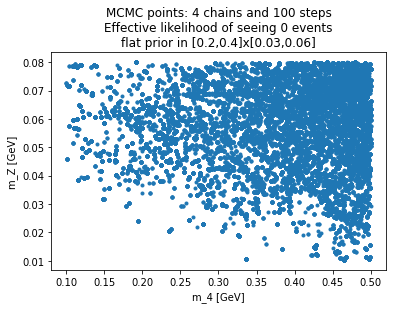

In [112]:
plt.plot(samples[:,0], samples[:,1], '.')
plt.title('MCMC points: 4 chains and 100 steps\nEffective likelihood of seeing 0 events\nflat prior in [0.2,0.4]x[0.03,0.06]')
plt.xlabel('m_4 [GeV]')
plt.ylabel('m_Z [GeV]')
# plt.savefig(f"{save_folder}scatter_Nwalkers_{nwalkers}_nstep_{nstep}_{selection_step}.png", bbox_inches='tight', dpi=250)

Text(0, 0.5, 'm_Z [GeV]')

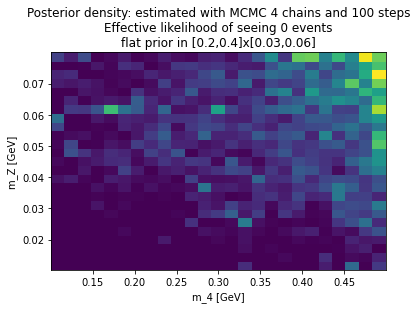

In [113]:
plt.hist2d(samples[:,0], samples[:,1], density=True, bins=(25, 25))
plt.title('Posterior density: estimated with MCMC 4 chains and 100 steps\nEffective likelihood of seeing 0 events\nflat prior in [0.2,0.4]x[0.03,0.06]')
plt.xlabel('m_4 [GeV]')
plt.ylabel('m_Z [GeV]')
# plt.savefig(f"{save_folder}density_Nwalkers_{nwalkers}_nstep_{nstep}_{selection_step}.png", bbox_inches='tight', dpi=250)

In [114]:
samples[:,2] = samples[:,2]*Vmu4
samples[:,3] = samples[:,3]*alpha_epsilon2
ctau_fit = ctau_light(samples[:, 0], samples[:, 1], samples[:,2])
aux_sample = np.concatenate([samples, ctau_fit[...,np.newaxis]], axis=1)
aux_sample_with_logs = aux_sample
aux_sample_with_logs[:,2] = np.log10(aux_sample_with_logs[:,2])
aux_sample_with_logs[:,3] = np.log10(axux_sample_with_logs[:,3])
aux_sample_with_logs[:,4] = np.log10(aux_sample_with_logs[:,4])

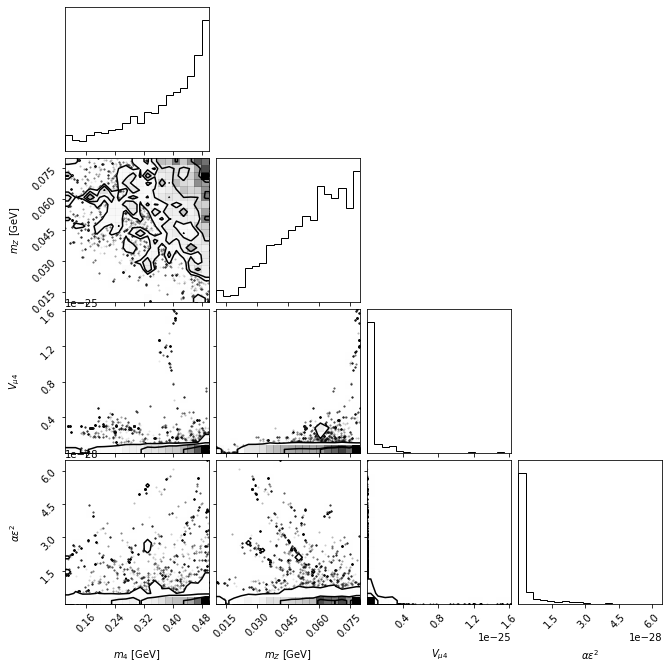

In [117]:
figure = corner.corner(samples, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$V_{\mu 4}$', r'$\alpha \epsilon^2$'])
# plt.savefig(save_folder + 'out_mcmc_4pars_16walkers.png', dpi=250)

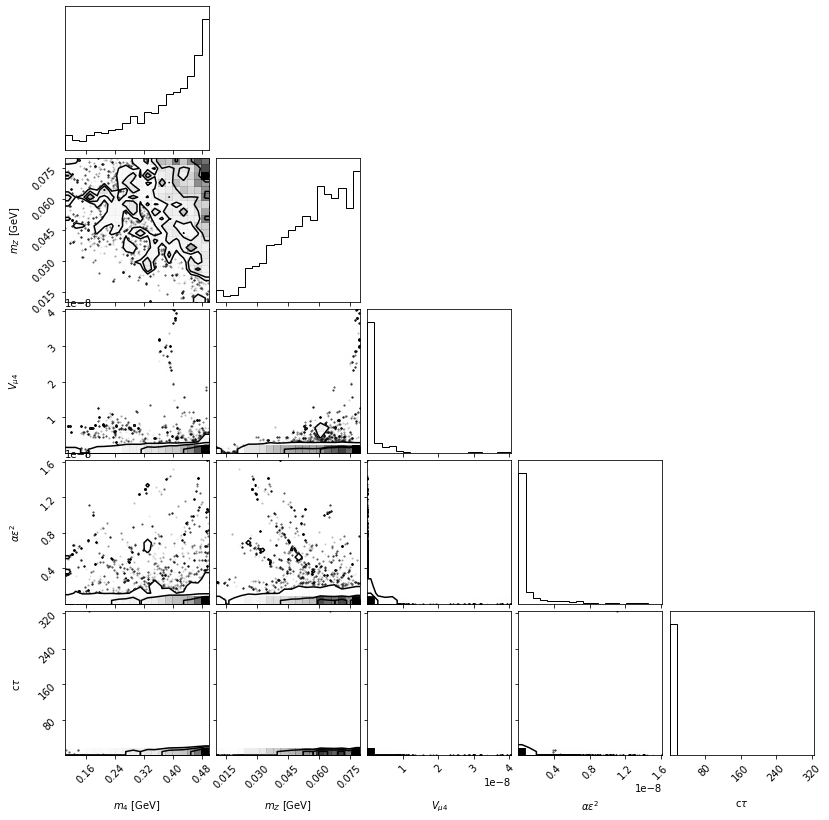

In [82]:
figure = corner.corner(aux_sample, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$V_{\mu 4}$', r'$\alpha \epsilon^2$', r'c$\tau$'])
plt.savefig(save_folder + 'contour_light_minimal.png', dpi=250)

In [104]:
plt.hist(np.log10(ctau_fit), bins=50)
plt.xlabel(r'$\log_{10}(c\tau$) [cm]')
plt.savefig(save_folder + 'ctau.png', dpi=250)

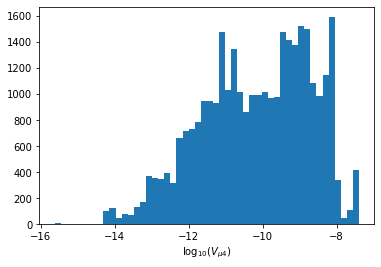

In [105]:
plt.hist(np.log10(samples[:,2]), bins=50)
plt.xlabel(r'$\log_{10}(V_{\mu 4}$)')
plt.savefig(save_folder + 'Vmu4.png', dpi=250)

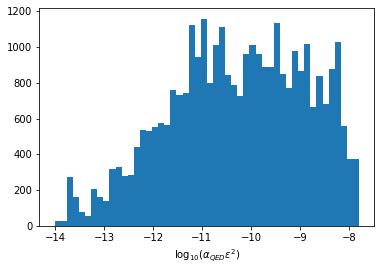

In [106]:
plt.hist(np.log10(samples[:,3]), bins=50)
plt.xlabel(r'$\log_{10}(\alpha_{QED}\epsilon^2$)')
plt.savefig(save_folder + 'alpha_epsilon2.png', dpi=250)

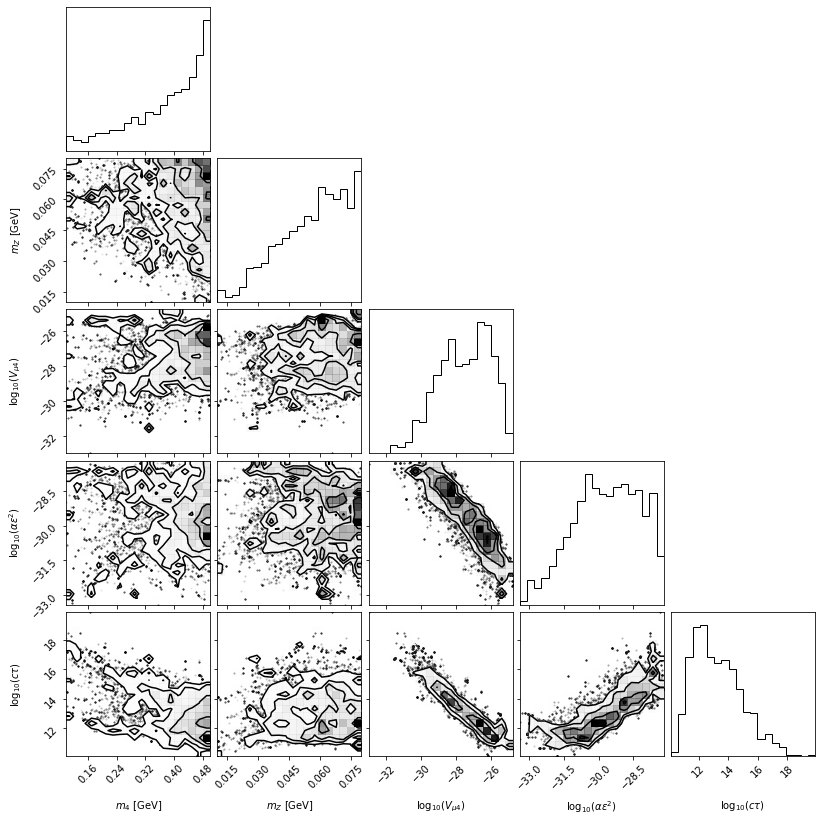

In [115]:
figure = corner.corner(aux_sample_with_logs, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$\log_{10}(V_{\mu 4})$', r'$\log_{10}(\alpha \epsilon^2)$', r'$\log_{10}(c\tau$)'])
plt.savefig(save_folder + 'contour_light_minimal_logs.png', dpi=250)